# Прогнозирование оттока клиентов

# Исследование


**Цель исследования** - определить, уйдет ли клиент в текущей ситуации, чтобы предложить ему специальные условия для предотвращения оттока клиентов.

## Контекст

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План исследования

- [1. Предобработка данных](#глава_1)  
    - [1.1 Загрузка данных](#раздел_1.1)  
    - [1.2 Устранение недостатков в данных](#раздел_1.2)  
    - [1.3 Объединение данных](#раздел_1.3)   
- [2. Исследовательский анализ данных](#глава_2)  
    - [2.1 Анализ количественных и категориальных данных](#раздел_2.1)  
    - [2.2 Матрица корреляции количественных признаков](#раздел_2.2)     
    - [2.3 Отбор признаков](#раздел_2.3)   
- [3. Подготовка данных к обучению, выбор и обучение моделей](#глава3)  
    - [3.1 Подготовка данных к обучению ](#раздел3.1)   
    - [3.2 Константная модель ](#раздел3.2)  
    - [3.3 Логистическая регрессия](#раздел3.3)  
    - [3.4 Random Forest](#раздел3.4)  
    - [3.5 Градиентный бустинг (CatBoost)](#раздел3.5)  
- [4. Выводы](#глава4)   
- [5. Отчет](#глава5)  

### Описание плана решения задачи

Решение задачи состоит из трех основных частей: 

1) Предобработка данных. Состоит из загрузки данных (а именно выгрузка данных из csv-файлов в объекты DataFrame), предобработки данных (а именно выявление пропусков, артефактов, дубликатов, приведение типов данных к необходимым, отброс лишних признаков и ввод новых), объединения данных (а именно получение одного датасета, с которым будет проводится дальнеший исследовательский анализ и доработка для обучения моделей)

2) Исследовательский анализ данных. Состоит из анализа данных и отбора признаков (а именно анализ распределений численных и категориальных данных, их корреляция между собой и окончательное формирование признаков для последующего обучения модели).

3) Выбор и обучение модели. Состоит из разбиения выборки на обучающую и тестовую, кодирования категориальных признаков в каждой выборке, выбора нескольких моделей, включая константную, которые будут обучены для решения поставленной задачи, подсчет метрик качества с помощью кросс-валидации на обучающей выборке, выбора на основе этого лучшей модели и проверка выбранной модели на тестовой выборке.

4) Выводы. Включают в себя сравнение моделей и их метрик качества, аргументированный выбор лучшей модели.

<a id='глава_1'></a>
# 1 Предобработка данных

<a id='раздел_1.1'></a>
## 1.1 Загрузка данных

In [23]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [24]:
# Импорт необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from tqdm.autonotebook import tqdm

In [25]:
pd.set_option('display.max_columns', None)

Поскольку во всех файлах столбец `customerID` содержит код клиента и он уникальный, используем его в качестве индекса.

In [26]:
#данные локально
data_path_local_0 = 'C:/Users/Maroznik/Documents/dev/Яндекс.Практикум/projects/data/final_project/final_provider/contract.csv'
data_path_local_1 = 'C:/Users/Maroznik/Documents/dev/Яндекс.Практикум/projects/data/final_project/final_provider/internet.csv'
data_path_local_2 = 'C:/Users/Maroznik/Documents/dev/Яндекс.Практикум/projects/data/final_project/final_provider/personal.csv'
data_path_local_3 = 'C:/Users/Maroznik/Documents/dev/Яндекс.Практикум/projects/data/final_project/final_provider/phone.csv'
'''
#данные на сервере
data_path_server_0 = '/content/datasets/contract.csv'
data_path_server_1 = '/content/datasets/internet.csv'
data_path_server_2 = '/content/datasets/personal.csv'
data_path_server_3 = '/content/datasets/phone.csv'
'''

#данные на сервере
data_path_server_1 = '/datasets/final_provider/contract.csv'
data_path_server_2 = '/datasets/final_provider/internet.csv'
data_path_server_3 = '/datasets/final_provider/personal.csv'
data_path_server_4 = '/datasets/final_provider/phone.csv'

if (os.path.exists(data_path_local_0) and \
   os.path.exists(data_path_local_1) and \
   os.path.exists(data_path_local_2) and \
   os.path.exists(data_path_local_3)):
    contract = pd.read_csv(data_path_local_0, sep=',', index_col='customerID')
    internet = pd.read_csv(data_path_local_1, sep=',', index_col='customerID')
    personal = pd.read_csv(data_path_local_2, sep=',', index_col='customerID')
    phone = pd.read_csv(data_path_local_3, sep=',', index_col='customerID')
    print('Успешное чтение локальных файлов')
elif (os.path.exists(data_path_server_0) and \
     os.path.exists(data_path_server_1) and \
     os.path.exists(data_path_server_2) and \
     os.path.exists(data_path_server_3)):
    contract = pd.read_csv(data_path_server_0, sep=',', index_col='customerID')
    internet = pd.read_csv(data_path_server_1, sep=',', index_col='customerID')
    personal = pd.read_csv(data_path_server_2, sep=',', index_col='customerID')
    phone = pd.read_csv(data_path_server_3, sep=',', index_col='customerID')
    print('Успешное чтение файлов с сервера')
else:
    print('Путь к файлу не найден')

Успешное чтение файлов с сервера


<a id='раздел_1.2'></a>
## 1.2 Устранение недостатков в данных

Поскольку все custumerID уникальные, дубликатов быть не может.
В качестве недостатков, которые обязательно необходимо устранить, выделим следующие:
- Пропуски и артефакты в данных (обрабатываем при наличии)
- Неподходящие типы данных (строковые категориальные данные кодируем, числовые данные преобразуем из строк, даты приводим к формату `datetime`)
- При наличии скрытых дубликатов они проявятся на этапе кодирования категориальных признаков. Привести к нижнему регистру при необходимости

**a) contract.csv**

In [27]:
display(contract.info())
display(contract.head())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


**Описание данных**

- `customerID`       — идентификатор клиента
- `BeginDate`        — дата заключения договора
- `EndDate`          — дата расторжения договора
- `Type`             — периодичность абонентской платы
- `PaperlessBilling` — электронный чек
- `PaymentMethod`    — тип оплаты
- `MonthlyCharges`   — ежемесячный платеж
- `TotalCharges`     — всего оплачено

Если клиент не разорвал контракт, то в поле запишем день выгрузки данных. Таким образом разметим неразорвавших контракт клиентов.

In [28]:
# Дата выгрузки 2020-02-01
UPLOAD_DATE = '2020-02-01'

In [29]:
# Разметим действующих клиентов
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = UPLOAD_DATE

In [30]:
#приведем даты к соответствующему формату
contract['BeginDate'] = contract['BeginDate'].astype('datetime64')
contract['EndDate'] = contract['EndDate'].astype('datetime64')

От дат перейдем к количеству дней, истекших до даты выгрузки от заключения и от разрыва контракта:

In [31]:
contract['days_from_begin'] = (pd.Timestamp(UPLOAD_DATE) - contract['BeginDate']) // np.timedelta64(1, 'D')
contract.drop('BeginDate', axis=1, inplace=True)
contract['days_from_end'] = (pd.Timestamp(UPLOAD_DATE) - contract['EndDate']) // np.timedelta64(1, 'D')
contract.drop('EndDate', axis=1, inplace=True)

In [32]:
contract.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days_from_begin,days_from_end
customerID,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,31,0
5575-GNVDE,One year,No,Mailed check,56.95,1889.5,1036,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,123,62
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,1371,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,153,92


Введем целевой признак- `exited`

In [33]:
contract['exited'] = (contract['days_from_end'] > 0).astype('int8')

In [34]:
contract.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days_from_begin,days_from_end,exited
customerID,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,31,0,0
5575-GNVDE,One year,No,Mailed check,56.95,1889.5,1036,0,0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,123,62,1
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,1371,0,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,153,92,1


При попытке конвертировать столбец `TotalCharges` к типу `float` появляется ошибка при конвертировании из пустой строки. Заполним эти значения суммой ежемесячного платежа:

In [35]:
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract.loc[contract['TotalCharges'] == ' ', 'MonthlyCharges']

In [36]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

In [37]:
str_columns = ['Type', 'PaperlessBilling', 'PaymentMethod']
for column in str_columns:
    print(f'Множество значений в столбце "{column}" :\n  {contract[column].unique()}')

Множество значений в столбце "Type" :
  ['Month-to-month' 'One year' 'Two year']
Множество значений в столбце "PaperlessBilling" :
  ['Yes' 'No']
Множество значений в столбце "PaymentMethod" :
  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Пропусков нет.

In [38]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   days_from_begin   7043 non-null   int64  
 6   days_from_end     7043 non-null   int64  
 7   exited            7043 non-null   int8   
dtypes: float64(2), int64(2), int8(1), object(3)
memory usage: 447.1+ KB


**б) personal.csv**

In [39]:
display(personal.info())
display(personal.head())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [40]:
str_columns = ['gender', 'Partner', 'Dependents']
for column in str_columns:
    print(f'Множество значений в столбце "{column}" :\n  {personal[column].unique()}')

Множество значений в столбце "gender" :
  ['Female' 'Male']
Множество значений в столбце "Partner" :
  ['Yes' 'No']
Множество значений в столбце "Dependents" :
  ['No' 'Yes']


Пропусков нет.

**Описание данных**

- `customerID`    — идентификатор клиента
- `gender`        — пол
- `SeniorCitizen` — пожилой клиент
- `Partner`       — партнер
- `Dependents`    — иждивенцы

**в) internet.csv**

In [41]:
display(internet.info())
display(internet.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


**Описание данных**

- `customerID`      — идентификатор клиента
- `InternetService` — тип интернет подключения
- остальные столбцы - дополнительные услуги

**г) phone.csv**

In [42]:
display(phone.info())
display(phone.head())

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [43]:
str_columns = ['MultipleLines']
for column in str_columns:
    print(f'Множество значений в столбце "{column}" :\n  {phone[column].unique()}')

Множество значений в столбце "MultipleLines" :
  ['No' 'Yes']


Пропусков нет.

<a id='раздел_1.3'></a>
## 1.3 Объединение данных

При объединении таблиц заполним пустые значения признаков значением `No`. В этом случае будем считать, что клиент не пользуется данными услугами.

In [44]:
data = contract.join(personal, how='left').join(internet, how='left').join(phone, how='left').fillna('No')

In [45]:
display(data.head())
display(data.info())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days_from_begin,days_from_end,exited,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,31,0,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,1036,0,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,123,62,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,1371,0,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,153,92,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   days_from_begin   7043 non-null   int64  
 6   days_from_end     7043 non-null   int64  
 7   exited            7043 non-null   int8   
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null 

None

In [46]:
str_columns = ['Type', 'PaperlessBilling', 'PaymentMethod',
               'gender', 'Partner', 
               'Dependents', 'InternetService', 
               'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies', 
               'MultipleLines']
for column in str_columns:
    print(f'Множество значений в столбце "{column}" :\n  {data[column].unique()}')

Множество значений в столбце "Type" :
  ['Month-to-month' 'One year' 'Two year']
Множество значений в столбце "PaperlessBilling" :
  ['Yes' 'No']
Множество значений в столбце "PaymentMethod" :
  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Множество значений в столбце "gender" :
  ['Female' 'Male']
Множество значений в столбце "Partner" :
  ['Yes' 'No']
Множество значений в столбце "Dependents" :
  ['No' 'Yes']
Множество значений в столбце "InternetService" :
  ['DSL' 'Fiber optic' 'No']
Множество значений в столбце "OnlineSecurity" :
  ['No' 'Yes']
Множество значений в столбце "OnlineBackup" :
  ['Yes' 'No']
Множество значений в столбце "DeviceProtection" :
  ['No' 'Yes']
Множество значений в столбце "TechSupport" :
  ['No' 'Yes']
Множество значений в столбце "StreamingTV" :
  ['No' 'Yes']
Множество значений в столбце "StreamingMovies" :
  ['No' 'Yes']
Множество значений в столбце "MultipleLines" :
  ['No' 'Yes']


Пропусков нет.

<a id='глава_2'></a>
# 2 Исследовательский анализ данных

<a id='раздел_2.1'></a>
## 2.1 Анализ количественных и категориальных данных

In [47]:
data.describe()

,MonthlyCharges,TotalCharges,days_from_begin,days_from_end,exited,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,1006.457050,20.460883,0.265370,0.162147
std,30.090047,2266.730170,736.596428,38.279807,0.441561,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,306.000000,0.000000,0.000000,0.000000
50%,70.350000,1394.550000,883.000000,0.000000,0.000000,0.000000
75%,89.850000,3786.600000,1706.000000,31.000000,1.000000,0.000000
max,118.750000,8684.800000,2314.000000,123.000000,1.000000,1.000000


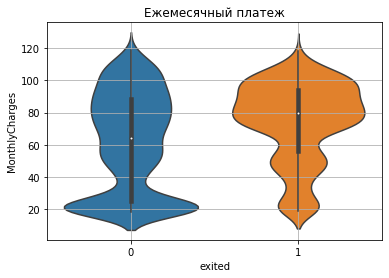

In [48]:
sns.violinplot(x='exited', y='MonthlyCharges', data=data)
plt.title('Ежемесячный платеж')
plt.grid()
plt.show()

Наибольшее количество ушедших клиентов имели высокий ежемесячный платеж (медиана = 80), что примерно на треть больше, чем у оставшихся.

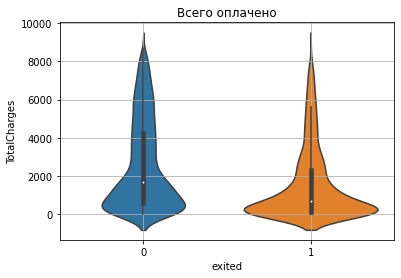

In [49]:
sns.violinplot(x='exited', y='TotalCharges', data=data)
plt.title('Всего оплачено')
plt.grid()
plt.show()

'TotalCharges' больше у оставшихся клиентов, что косвенно говорит о том, что уходят в основном новые клиенты.

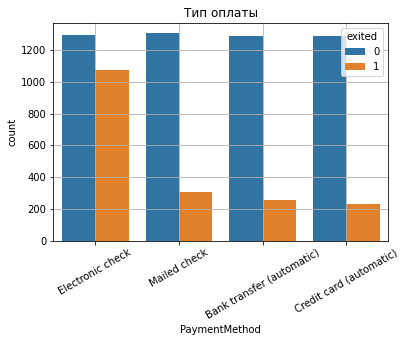

In [50]:
sns.countplot(x='PaymentMethod', hue='exited', data=data)
plt.xticks(rotation = 30) 
plt.title('Тип оплаты')
plt.grid()
plt.show()

Подавляющее большинство ушедших клиентов расплачивались методом 'Electronic check'.

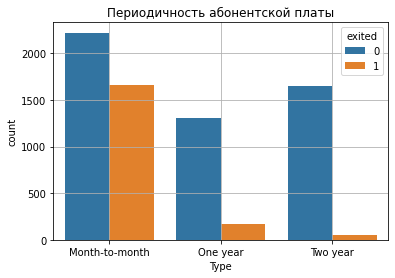

In [51]:
sns.countplot(x='Type', hue='exited', data=data)
plt.title('Периодичность абонентской платы')
plt.grid()
plt.show()

Подавляющее большинство ушедших клиентов платили ежемесячно.

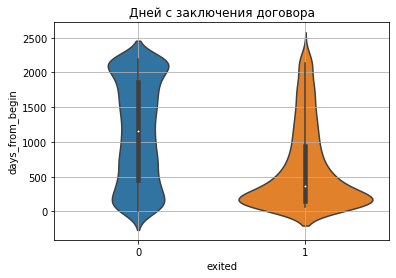

In [52]:
sns.violinplot(x='exited', y='days_from_begin', data=data)
plt.title('Дней с заключения договора')
plt.grid()
plt.show()

Многие ушедшие клиенты начали пользоваться услугами в течение последних 1-2 лет. Предположение подтверждено.

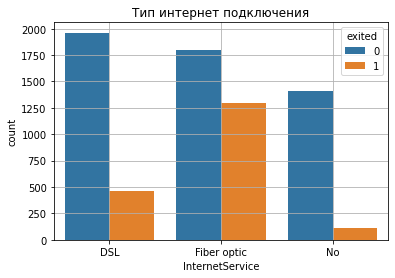

In [53]:
sns.countplot(x='InternetService', hue='exited', data=data)
plt.title('Тип интернет подключения')
plt.grid()
plt.show()

Многие ушедшие клиенты пользовались оптоволоконным интернетом. Пользователей, которые ушли, не будучи подключенными к интернету, относительно мало.

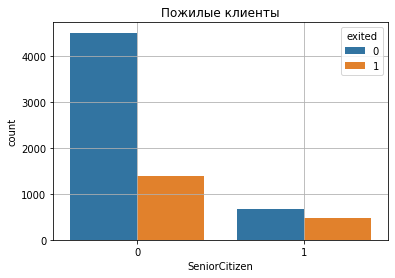

In [54]:
sns.countplot(x='SeniorCitizen', hue='exited', data=data)
plt.title('Пожилые клиенты')
plt.grid()
plt.show()

Пожилих клиентов в пропорции к непожилым клиентам ушло значительно больше, чем осталось.

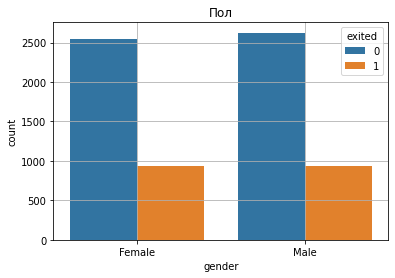

In [55]:
sns.countplot(x='gender', hue='exited', data=data)
plt.title('Пол')
plt.grid()
plt.show()

Различий по полу нет.

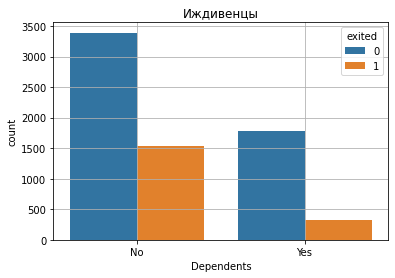

In [56]:
sns.countplot(x='Dependents', hue='exited', data=data)
plt.title('Иждивенцы')
plt.grid()
plt.show()

Уходят в основном не иждивенцы, что косвенно говорит о зависимости от стоимости предоставляемых услуг (когда клиент сам селдит за своими финансами)

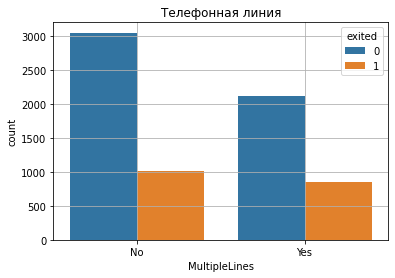

In [57]:
sns.countplot(x='MultipleLines', hue='exited', data=data)
plt.title('Телефонная линия')
plt.grid()
plt.show()

Ушедших пользователей, не пользовавшихся телефонной линией немного. Различия между пользователями моно- и мультилинией практически отсутствуют.

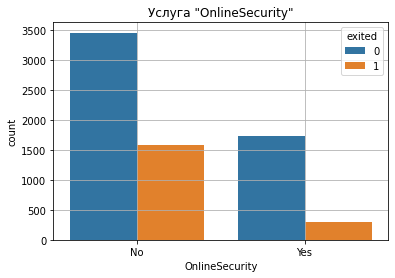

In [58]:
sns.countplot(x='OnlineSecurity', hue='exited', data=data)
plt.title('Услуга "OnlineSecurity"')
plt.grid()
plt.show()

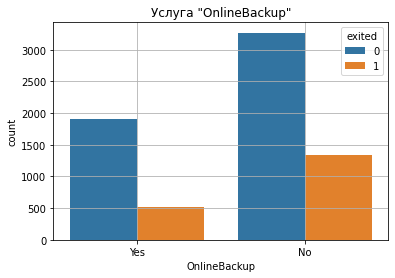

In [59]:
sns.countplot(x='OnlineBackup', hue='exited', data=data)
plt.title('Услуга "OnlineBackup"')
plt.grid()
plt.show()

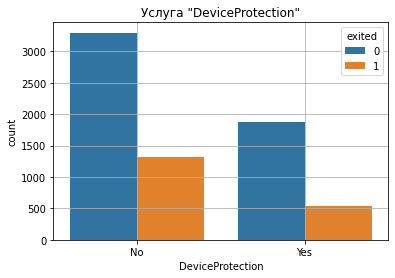

In [60]:
sns.countplot(x='DeviceProtection', hue='exited', data=data)
plt.title('Услуга "DeviceProtection"')
plt.grid()
plt.show()

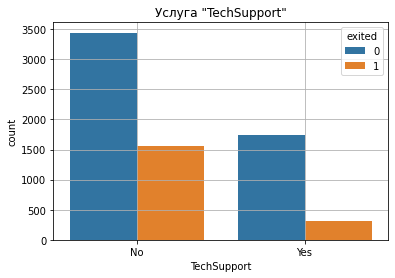

In [61]:
sns.countplot(x='TechSupport', hue='exited', data=data)
plt.title('Услуга "TechSupport"')
plt.grid()
plt.show()

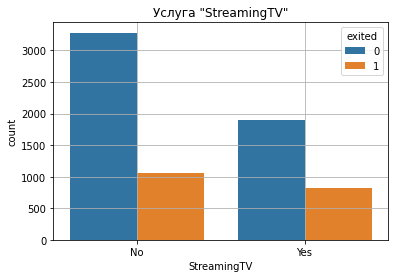

In [62]:
sns.countplot(x='StreamingTV', hue='exited', data=data)
plt.title('Услуга "StreamingTV"')
plt.grid()
plt.show()

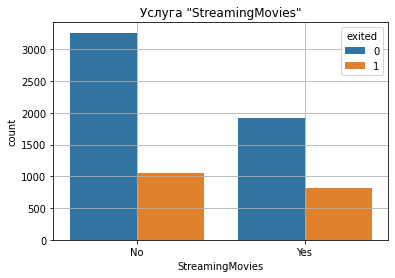

In [63]:
sns.countplot(x='StreamingMovies', hue='exited', data=data)
plt.title('Услуга "StreamingMovies"')
plt.grid()
plt.show()

Из аналиа дополнительных услуг можно сделать вывод, что значительно чаще уходили клиенты, пользовавшиеся услугами ТВ и кино, чем пользователи дополнительных услуг, связанных с интернетом. Можно сделать предположение, что часть клиентов осталась недовольна возможностями ТВ и кино.

<a id='раздел_2.2'></a>
## 2.2 Матрица корреляции количественных признаков

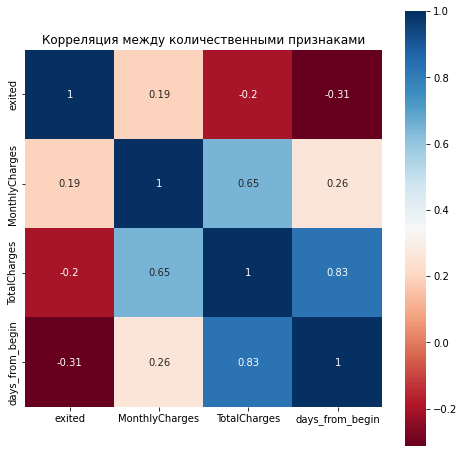

In [64]:
str_columns = ['exited', 'MonthlyCharges', 'TotalCharges', 'days_from_begin']
correlation = data[str_columns].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='RdBu')

plt.title('Корреляция между количественными признаками')
plt.show()

Из матрицы видно, что по шкале Чеддока связь между суммарными выплатами и количеством дней с заключения договора высокая, а связь между суммарными выплатами и ежемесячными платежами средняя, что логично. Остальные параметры очень слабо коррелируют между собой.

<a id='раздел_2.3'></a>
## 2.3 Отбор признаков

По результатам проведенного анализа можно сделать вывод, что от признака пола клиента можно отказаться, а два количественных значения временных интервалов от начала и конца действия договора нужно заменить на один- длительность действия договора

In [65]:
data['duration'] = data['days_from_begin'] - data['days_from_end']
data.drop(['days_from_begin', 'days_from_end', 'gender'], axis=1, inplace=True)
num_columns = ['MonthlyCharges', 'TotalCharges', 'duration']
cat_columns = [column for column in list(data.columns) if column not in num_columns and column != 'exited']

In [66]:
display(data.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,exited,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,0,No,No,Fiber optic,No,No,No,No,No,No,No,61


**Выводы**

- Данные успешно загружены и обработаны. Выбросы, дубликаты и пропуски среди исходных данных отсутствуют. Строковые типы преобразованы к числовым категориям, даты приведены сначала к типу datetime, а затем в количество дней.
- Проведён анализ признаков. 
    - в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся
    - многие ушедшие клиенты расплачивались методом 'Electronic check'
    - большинство ушедших клиентов были подключены в течение 1-2 лет
    - большинство ушедших клиентов использовали ежемесячный тип оплаты
    - большинство ушедших клиентов были подключены по оптоволокну
    - существенная доля ушедших - это пожилые клиенты
    - среди ушедших больше тех кто пользовался ТВ и киносервисами, чем интернет сервисами
    - среди клиентов, не пользовавшихся услугами интернета, отток сравнительно небольшой  
- Построена матрица корреляции и отобраны наиболее релевантные для модели признаки

<a id='глава3'></a>
# 3 Подготовка данных к обучению, выбор и обучение моделей

<a id='раздел3.1'></a>
### 3.1 Подготовка данных к обучению 

In [67]:
data['exited'].value_counts()

0    5174
1    1869
Name: exited, dtype: int64

Отношение оставшихся клиентов к ушедшим в выборке примерно 3:1. Проводить балансирование классов при помощи upsampling не будем, но учтем это при помощи class_weight='balanced', а при разделении данных на train-validation-test надо учесть это соотношение при помощи stratify.
Разделим выборку на обучающую и тестовую в соотношении 3:1:

In [68]:
X = data.drop('exited', axis=1)
y = data['exited']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=120922, stratify=y)

In [70]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (5282, 17)
Размер тестовой выборки: (1761, 17)


Проведем кодирование категориальных переменных

In [71]:
cat_columns

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [72]:
ohe_enc = OneHotEncoder(drop='first')
ohe_enc.fit(X_train[cat_columns])
new_columns = ohe_enc.get_feature_names(cat_columns)
X_train_ohe = pd.DataFrame(ohe_enc.transform(X_train[cat_columns]).toarray(), columns=new_columns, index=X_train.index)
X_train_ohe = X_train.join(X_train_ohe)
display(X_train_ohe.head())
display(X_train_ohe.info())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7643-RCHXS,Two year,No,Electronic check,19.35,1263.85,0,Yes,Yes,No,No,No,No,No,No,No,No,1918,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8019-ENHXU,Month-to-month,Yes,Electronic check,99.45,4138.05,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,No,Yes,Yes,1279,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3714-JTVOV,Month-to-month,Yes,Credit card (automatic),74.15,3229.40,1,Yes,No,Fiber optic,Yes,No,No,No,No,No,No,1279,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4685-ERGHK,One year,Yes,Electronic check,86.90,4939.25,0,No,No,Fiber optic,No,No,No,No,Yes,No,Yes,1737,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6683-VLCTZ,Month-to-month,Yes,Electronic check,98.55,1842.80,1,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,609,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 7643-RCHXS to 7359-WWYJV
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Type                                   5282 non-null   object 
 1   PaperlessBilling                       5282 non-null   object 
 2   PaymentMethod                          5282 non-null   object 
 3   MonthlyCharges                         5282 non-null   float64
 4   TotalCharges                           5282 non-null   float64
 5   SeniorCitizen                          5282 non-null   int64  
 6   Partner                                5282 non-null   object 
 7   Dependents                             5282 non-null   object 
 8   InternetService                        5282 non-null   object 
 9   OnlineSecurity                         5282 non-null   object 
 10  OnlineBackup                           5282 non-null   object 

None

Удалим категориальные признаки из датасета

In [73]:
X_train_ohe = X_train_ohe.drop(cat_columns, axis=1)
display(X_train_ohe.head())
display(X_train_ohe.info())

,MonthlyCharges,TotalCharges,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7643-RCHXS,19.35,1263.85,1918,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8019-ENHXU,99.45,4138.05,1279,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3714-JTVOV,74.15,3229.40,1279,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4685-ERGHK,86.90,4939.25,1737,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6683-VLCTZ,98.55,1842.80,609,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 7643-RCHXS to 7359-WWYJV
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5282 non-null   float64
 1   TotalCharges                           5282 non-null   float64
 2   duration                               5282 non-null   int64  
 3   Type_One year                          5282 non-null   float64
 4   Type_Two year                          5282 non-null   float64
 5   PaperlessBilling_Yes                   5282 non-null   float64
 6   PaymentMethod_Credit card (automatic)  5282 non-null   float64
 7   PaymentMethod_Electronic check         5282 non-null   float64
 8   PaymentMethod_Mailed check             5282 non-null   float64
 9   SeniorCitizen_1                        5282 non-null   float64
 10  Partner_Yes                            5282 non-null   float64

None

Сделаем то же самое для тестовой выборки

In [74]:
X_test_ohe = pd.DataFrame(ohe_enc.transform(X_test[cat_columns]).toarray(), columns=new_columns, index=X_test.index)
X_test_ohe = X_test.join(X_test_ohe)
display(X_test_ohe.head())
display(X_test_ohe.info())
X_test_ohe = X_test_ohe.drop(cat_columns, axis=1)
display(X_test_ohe.head())
display(X_test_ohe.info())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2400-XIWIO,Two year,No,Electronic check,90.10,6310.90,0,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2163,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2272-UOINI,Month-to-month,Yes,Electronic check,78.50,571.05,0,No,No,DSL,Yes,Yes,No,Yes,Yes,Yes,No,215,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
7240-FQLHE,Month-to-month,No,Bank transfer (automatic),99.75,1836.25,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,Yes,Yes,549,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2074-GKOWZ,Month-to-month,Yes,Bank transfer (automatic),89.55,185.55,0,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,No,61,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4177-JPDFU,Month-to-month,No,Mailed check,34.00,442.45,0,No,No,DSL,No,Yes,No,Yes,No,No,No,365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 2400-XIWIO to 3889-VWBID
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Type                                   1761 non-null   object 
 1   PaperlessBilling                       1761 non-null   object 
 2   PaymentMethod                          1761 non-null   object 
 3   MonthlyCharges                         1761 non-null   float64
 4   TotalCharges                           1761 non-null   float64
 5   SeniorCitizen                          1761 non-null   int64  
 6   Partner                                1761 non-null   object 
 7   Dependents                             1761 non-null   object 
 8   InternetService                        1761 non-null   object 
 9   OnlineSecurity                         1761 non-null   object 
 10  OnlineBackup                           1761 non-null   object 

None

,MonthlyCharges,TotalCharges,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
2400-XIWIO,90.10,6310.90,2163,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2272-UOINI,78.50,571.05,215,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
7240-FQLHE,99.75,1836.25,549,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2074-GKOWZ,89.55,185.55,61,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4177-JPDFU,34.00,442.45,365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 2400-XIWIO to 3889-VWBID
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         1761 non-null   float64
 1   TotalCharges                           1761 non-null   float64
 2   duration                               1761 non-null   int64  
 3   Type_One year                          1761 non-null   float64
 4   Type_Two year                          1761 non-null   float64
 5   PaperlessBilling_Yes                   1761 non-null   float64
 6   PaymentMethod_Credit card (automatic)  1761 non-null   float64
 7   PaymentMethod_Electronic check         1761 non-null   float64
 8   PaymentMethod_Mailed check             1761 non-null   float64
 9   SeniorCitizen_1                        1761 non-null   float64
 10  Partner_Yes                            1761 non-null   float64

None

Кодирование проведено успешно

<a id='раздел3.2'></a>
### 3.2 Константная модель 

Используем константную модель (все объекты класса 0, соответствующего оставшимся клиентам).

In [75]:
#Функция построения графика и подсчета метрик качества
def roc(model, features, target):
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    auc_roc = roc_auc_score(target, probabilities_one_valid)
    accuracy = accuracy_score(target, model.predict(X_test))
    print(f'AUC-ROC = {auc_roc}')
    print(f'accuracy = {accuracy}')

In [76]:
pred_const = [0] * y_train.shape[0]
roc_auc_const = roc_auc_score(y_train.values, pred_const)
print(f"roc_auc для константной модели: {roc_auc_const:.3f}")
accuracy_const = accuracy_score(y_train.values, pred_const)
print(f"accuracy для константной модели: {accuracy_const:.3f}")

roc_auc для константной модели: 0.500
accuracy для константной модели: 0.735


<a id='раздел3.3'></a>
### 3.3 Логистическая регрессия

Для логистической регрессии проведем масштабирование признаков:

In [77]:
X_train_ohe_s = X_train_ohe.copy()
X_test_ohe_s = X_test_ohe.copy()
scaler = StandardScaler()
scaler.fit(X_train_ohe[num_columns])
X_train_ohe_s[num_columns] = scaler.transform(X_train_ohe[num_columns])
X_test_ohe_s[num_columns] = scaler.transform(X_test_ohe[num_columns])
display(X_train_ohe.head())
display(X_test_ohe.head())
display(X_train_ohe_s.head())
display(X_test_ohe_s.head())

,MonthlyCharges,TotalCharges,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7643-RCHXS,19.35,1263.85,1918,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8019-ENHXU,99.45,4138.05,1279,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3714-JTVOV,74.15,3229.40,1279,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4685-ERGHK,86.90,4939.25,1737,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6683-VLCTZ,98.55,1842.80,609,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


,MonthlyCharges,TotalCharges,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
2400-XIWIO,90.10,6310.90,2163,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2272-UOINI,78.50,571.05,215,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
7240-FQLHE,99.75,1836.25,549,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2074-GKOWZ,89.55,185.55,61,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4177-JPDFU,34.00,442.45,365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


,MonthlyCharges,TotalCharges,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7643-RCHXS,-1.509839,-0.445026,1.250370,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8019-ENHXU,1.154705,0.822328,0.395402,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3714-JTVOV,0.313095,0.421666,0.395402,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4685-ERGHK,0.737226,1.175610,1.008196,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6683-VLCTZ,1.124766,-0.189743,-0.501043,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


,MonthlyCharges,TotalCharges,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
2400-XIWIO,0.843675,1.780428,1.578175,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2272-UOINI,0.457799,-0.750511,-1.028206,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
7240-FQLHE,1.164685,-0.192631,-0.581322,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2074-GKOWZ,0.825379,-0.920494,-1.234255,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4177-JPDFU,-1.022504,-0.807216,-0.827509,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Масштабирование выполнено успешно.

Также, поскольку такие признаки как количество дней от заключения договора (а значит и длительность действия договора) сильно коррелируют с признаком "общие выплаты", то, для избежания мультиколлинеарности, удалим признак общих выплат из рассмотрения

In [78]:
X_train_ohe_s = X_train_ohe_s.drop('TotalCharges', axis=1)
X_test_ohe_s = X_test_ohe_s.drop('TotalCharges', axis=1)

In [79]:
model_lr = LogisticRegression(random_state=120922, solver='liblinear', class_weight='balanced')
roc_auc_lr_v = cross_val_score(model_lr, X_train_ohe_s, y_train, cv=5, scoring='roc_auc').mean()
print(f"roc_auc для модели Логистической Регрессии на кросс-валидации: {roc_auc_lr_v:.3f}")
accuracy_lr = cross_val_score(model_lr, X_train_ohe_s, y_train, cv=5, scoring='accuracy').mean()
print(f"accuracy для модели Логистической Регрессии на кросс-валидации: {accuracy_lr:.3f}")

roc_auc для модели Логистической Регрессии на кросс-валидации: 0.842
accuracy для модели Логистической Регрессии на кросс-валидации: 0.748


<a id='раздел3.4'></a>
### 3.4 Модель RandomForest

Параметры для модели Random Forest подберём с помощью GridSearchCV

In [80]:
parametrs = {'n_estimators': [500],
              'max_depth': range (12,20),
              'min_samples_split': range (2,14,2),
              'min_samples_leaf': range (2,14,2),
             }

model_rf = RandomForestClassifier(random_state=120922)
grid_search_rf = GridSearchCV(estimator=model_rf,
                           param_grid=parametrs,
                           cv=5,
                           verbose = 2,
                           scoring = 'roc_auc')
grid_search_rf.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.6s
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.9s
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.9s
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.7s
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.1s
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   4.5s
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   2.5s
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   2.5s
[CV] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=500; total time=   2.4s
[CV] END max_depth=12, min_

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=120922),
             param_grid={'max_depth': range(12, 20),
                         'min_samples_leaf': range(2, 14, 2),
                         'min_samples_split': range(2, 14, 2),
                         'n_estimators': [500]},
             scoring='roc_auc', verbose=2)

In [81]:
print('Параметры лучшей модели случайного леса: ', grid_search_rf.best_params_)
print(f"roc_auc для модели Random Forest на кросс валидации: {grid_search_rf.best_score_:.3f}")

Параметры лучшей модели случайного леса:  {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
roc_auc для модели Random Forest на кросс валидации: 0.858


<a id='раздел3.5'></a>
### 3.5 Градиентный бустинг (CatBoost)

In [82]:
model_cbr = CatBoostClassifier (loss_function="CrossEntropy",  
                                iterations=2000,
                                eval_metric = 'AUC',
                                cat_features = cat_columns,
                                random_state=120922)
parametrs = { 'depth': range (6, 12),
              'learning_rate': np.arange (0.1,0.6,0.1) }
grid_cbr = GridSearchCV(estimator=model_cbr, param_grid=parametrs, scoring='roc_auc', cv=5)
grid_cbr.fit(X_train, y_train, cat_features=cat_columns, verbose=False)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f6bc8793b90>,
             param_grid={'depth': range(6, 12),
                         'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5])},
             scoring='roc_auc')

In [83]:
display(grid_cbr.best_params_)
display(grid_cbr.cv_results_.get('mean_test_score'))

{'depth': 6, 'learning_rate': 0.1}

array([0.90707409, 0.90104868, 0.89908183, 0.89764436, 0.89220413,
       0.9010891 , 0.89614308, 0.89386091, 0.88926041, 0.88923046,
       0.89395071, 0.88954667, 0.88468061, 0.88385433, 0.88177678,
       0.88576495, 0.88187137, 0.87712215, 0.87323465, 0.87336742,
       0.88195854, 0.87459918, 0.87240334, 0.86962988, 0.86464441,
       0.87170876, 0.86878046, 0.86533814, 0.86346146, 0.85800923])

Таким образом нашли наилучшие параметры для модели CatBoost. Используем их для дальнейшего исследования

In [89]:
best_model_cb = CatBoostClassifier (loss_function="CrossEntropy",  
                                iterations=2000,
                                learning_rate = 0.1,
                                depth = 6,
                                eval_metric = 'AUC',
                                cat_features = cat_columns,
                                random_state=120922)

In [90]:
best_model_cb.fit(X_train, y_train, cat_features=cat_columns, verbose=150)

0:	total: 9.31ms	remaining: 18.6s
150:	total: 1.34s	remaining: 16.4s
300:	total: 2.78s	remaining: 15.7s
450:	total: 4.25s	remaining: 14.6s
600:	total: 5.7s	remaining: 13.3s
750:	total: 7.16s	remaining: 11.9s
900:	total: 8.62s	remaining: 10.5s
1050:	total: 10.1s	remaining: 9.09s
1200:	total: 11.5s	remaining: 7.65s
1350:	total: 13s	remaining: 6.24s
1500:	total: 14.4s	remaining: 4.8s
1650:	total: 15.9s	remaining: 3.36s
1800:	total: 17.4s	remaining: 1.92s
1950:	total: 18.9s	remaining: 474ms
1999:	total: 19.4s	remaining: 0us


In [91]:
params = {
    'loss_function': 'CrossEntropy',
    'iterations': 2000,
    'learning_rate': 0.1,
    'depth': 6,
    'eval_metric': 'AUC',
    'random_state': 120922
}

In [92]:
cv_data = cv(
    params=params,
    pool=Pool(X_train, label=y_train, cat_features=cat_columns),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем данные
    partition_random_seed=0,
    stratified=True, 
    verbose=False
)

Training on fold [0/5]

bestTest = 0.9265280478
bestIteration = 651

Training on fold [1/5]

bestTest = 0.9055999376
bestIteration = 757

Training on fold [2/5]

bestTest = 0.8918745398
bestIteration = 846

Training on fold [3/5]

bestTest = 0.9202917894
bestIteration = 1980

Training on fold [4/5]

bestTest = 0.8975170287
bestIteration = 527



In [93]:
prediction = best_model_cb.predict(X_test)

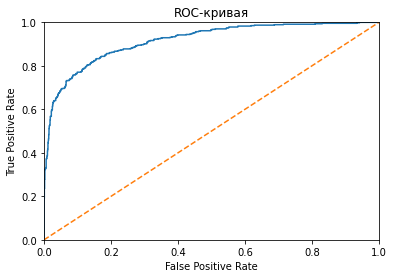

AUC-ROC = 0.9162631681719945
accuracy = 0.8813174332765474


In [94]:
roc(best_model_cb,X_test,y_test)

Доля вклада каждого признака в итоговое предсказание:

In [95]:
features_importances = pd.DataFrame(data = {'feature': X_train.columns, 'percent': best_model_cb.feature_importances_})
features_importances.sort_values('percent', ascending=False).reset_index(drop=True)

,feature,percent
0,duration,37.732909
1,MonthlyCharges,14.552174
2,TotalCharges,12.631743
3,Type,7.712893
4,PaymentMethod,5.754456
5,InternetService,4.862089
6,PaperlessBilling,2.307596
7,Partner,1.744636
8,SeniorCitizen,1.691437
9,MultipleLines,1.628716


<a id='глава4'></a>
# 4. Выводы

- Проведён анализ признаков и выявлены следующие закономерности.  
    - в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся
    - многие ушедшие клиенты расплачивались методом 'Electronic check'
    - большинство ушедших клиентов использовали оптоволоконный интернет.
    - среди клиентов, не пользовавшихся услугами интернета, отток сравнительно небольшой  
    - большинство из ушедших клиентов пользовались услугами ТВ и кино
    - большинство ушедших клиентов - платежеспособные
    - Обучены различные модели бинарной классификации для предсказания оттока клиентов. Для проверки качества моделей использовались метрики roc_auc и accuracy.  
  
| модель | roc_auc cv | roc_auc test | accuracy |  
|:------|:----------:|:------------:|:--------:|  
| Константная | 0.5 | - | 0.735 |  
| Логистическая регрессия | 0.842 | - | 0.748 |  
| Random Forest | 0.858 | - | - |  
| **CatBoost** | 0.92 | **0.916** | 0.881 |  
  
- Наилучшее качество предсказания показала модель градиентного бустинга (CatBoost). **roc_auc = 0.916** на тестовой выборке, accuracy = 0.881  
- Наибольший вклад в предсказание модели вносят признаки:
    - `duration` - количество дней, которое клиент пользуется сервисами
    - `MonthlyCharges` - ежемесячный платёж за услуги. Для ушедших пользователей этот показатель выше.
    - `Type` - тип платежей (ежемесячный, ежегодный, раз в два года)
    - `TotalCharges` - общая сумма, которую клиент заплатил за всё время услуг

<a id='глава5'></a>
# 5. Отчет

1) Итоговое решение по структуре соответствует плану. 

2) Предобработка заключалась в следующих шагах:
    
    При загрузке данных параметр `customerID` использовался в качестве индекса, поскольку он уникален для каджой записи и по этому индексу можно будет производить объединение таблиц из нескольких файлов в один датасет.

    а) для файла `contract.csv`:
    - преобразование типа параметров `BeginDate` и `EndDate` из строкового в `datetime`;
    - заполнение пропусков в параметре `EndDate` значением даты выгрузки данных (`2020-02-01`);
    - заполнение пропусков в параметре `TotalCharges` значением параметра `MonthlyCharges` этой строки, поскольку пропуски появляются в строках, где дата заключения договора совпадает с датой выгрузки данных (`2020-02-01`), а значит, клиент внёс оплату минимум за месяц;
    - преобразование типа параметра `TotalCharges`  из строкового в `float`;
    - на основе признаков `BeginDate` и `EndDate` вывод количественных признаков `days_from_begin` и `days_from_end` типа `float`, говорящих о количестве дней, истекших от начала/конца действия договора;
    - удаление признаков `BeginDate` и `EndDate`;
    - на основе признака `days_from_end` формируем целевой признак `exited`, в который записываем результат сравнения: `days_from_end > 0`, где `1` означает что клиент ушел, а `0` - что клиент лоялен.
    
    б) для файлов `personal.csv`, `internet.csv` и `phone.csv` предобработка не потребовалась.
    
    При "левом" объединении данных датасетов из файлов `personal.csv`, `internet.csv` и `phone.csv` к датасету из файла `contract.csv` появились пропуски в категориальных признаках, поскольку датасет из `contract.csv` наиболее полный в смысле количества клиентов. Пропуски означают, что клиент не пользуется указанной услугой, поэтому, по аналогии с содержимым категориальных признаков в таком случае, заполним такие пропуски значением `No`.
    
3) Для численного анализа данных использовался метод .describe(). Для графического представления количественных данных использовались диаграммы .violinplot с разделением по целевому признаку, а для категориальных данных- .countplot с разделением по целевому признаку.

4) Для проверки взаимосвязи количественных признаков использовалась матрица корреляции (сочетание методов .corr и .headmap)

5) По результатам анализа был сделан вывод о необходимости избавиться от таких признаков как `gender` (отсутствие влияния пола клиента), `days_from_begin` и `days_from_end` (два количественных параметра заменили на один - `duration` = `days_from_begin - days_from_end`)

6) При подготовке данных к обучению, было выявлено отношение оставшихся клиентов к ушедшим равное 3:1. Было принято решение искуственно не проводить увеличение выборки методом upsampling, а примененить аргумент `class_weight='balanced'`. При разделении выборки на обучающую и тестовую использовалась пропорция 3:1 с применением стратификации по целевому признаку (параметр `stratify`). Для моделей логистической регрессии и случайного леса сформировали отдельные датасеты, в которых произвели кодирование категориальных признаков методом OneHotEncoding (класс библиотеки sklearn), избегая дамми-ловушку и удалив после кодирования исходные категориальные признаки. Для модели логистической регрессии также произвели масштабирование количественных признаков методом StandartScaler (класс библиотеки sklearn) и удалили признак `TotalCharges` для избежания мульткорреляции с признаком `duration` (при анализе матрицы корреляции их связь сильная).

7) При проверке качества моделей использовалась кросс-валидация с разделением на пять подвыборок и скорингом `roc-auc`. Также вычислялась метрика `accuracy`

8) В модели случайного леса использовали инструмент `GridSearchCV` для поиска оптимальных гиперпараметров модели. Для этого использовались следующие диапазоны и шаги перебора параметров:

              - 'n_estimators': [500],
              - 'max_depth': range (12,20),
              - 'min_samples_split': range (2,14,2),
              - 'min_samples_leaf': range (2,14,2).
              
    В результате получили гиперпараметры: `'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500`.
    
9) Для модели градиентного бустинга CatBoost мы передали датасет без предварительно проведенного кодирования категориальных параметров, но передали список столбцов с категориальными параметрами. Также задали следующие параметры модели:

              - loss_function="CrossEntropy",  
              - iterations=2000,
              - eval_metric = 'AUC',
              - cat_features = cat_columns,
              - random_state=120922.
              
    Для поиска оптимальных гиперпараметров использовался `GridSearchCV` со следующими диапазонами и шагами перебора параметров:
    
              - 'depth': range (6, 12),
              - 'learning_rate': np.arange (0.1,0.6,0.1)
    В результате получили гиперпараметры: `'depth': 6, 'learning_rate': 0.1`.
    
10) В ходе сравнения полученных значений метрик на обучающей выборке, лучшей была признана модель градиентного бустинга, ее использовали для проверки на тестовой выборке и получили значение метрики `roc-auc = 0.916`, что является хорошим результатом. Наибольший вклад в предсказание модели вносят признаки `duration` (37.73 %), `MonthlyCharges` (14.55 %), `Type` (7.71 %), и `TotalCharges` (12.63 %).

11) При работой над проектом возникли два основных затруднения, решение которых позволило улучшить модели и получить корректную и высокую метрику `roc-auc`:

    а) При обучении модели логистической регрессии сначала не был исключен сильнокоррелирующий с другим параметр `TotalCharges`, что приводило к мультиколлинеарности и ухудшало качество модели. 
    
    б) На этапе предобработки данных, при заполнении пропусков в признаке `EndDate` изначально использовалась дата `2020-02-02` - следующая, после даты выгрузки данных. Также, в связи с этим изменился диапазон значений, принимаемый вычисляемым новым признаком `days_from_end`, а, следовательно, изменилось неравенство, по которому формировался целевой признак `days_from_end >= 0`. Негативное влияние данного смещения проявилось при обучении и тестировании модели градиентного бустинга: модель переобучалась и выдавала неправдоподобно высокие показатели качества как на кросс-валидации, так и на тестовой выборке (которая предобрабатывалась до разделения выборки на обучающую и тестовую). Данную проблему удалось решить заполнением пропусков датой выгрузки данных (`2020-02-01`), в результате чего получили качественную модель с высоким, адекватным показателем метрики `roc-auc`.

12) Таким образом были выделены следующие признаки для обучения модели и соответствующий каждому параметру процент вклада в итоговое предсказание:

    - duration	        37.732909
    - MonthlyCharges	14.552174
    - TotalCharges	    12.631743
    - Type	            7.712893
    - PaymentMethod	    5.754456
    - InternetService	4.862089
    - PaperlessBilling	2.307596
    - Partner	        1.744636
    - SeniorCitizen	    1.691437
    - MultipleLines	    1.628716
    - OnlineBackup	    1.612015
    - Dependents	    1.548121
    - TechSupport	    1.496139
    - OnlineSecurity	1.456225
    - StreamingMovies	1.118844
    - DeviceProtection	1.083651
    - StreamingTV       1.066356
    
    Лучшей моделью стала модель градиентного бустинга CatBoostClassifier со следующими гиперпараметрами:
    
    - loss_function="CrossEntropy",  
    - iterations=2000,
    - learning_rate = 0.1,
    - depth = 6,
    - eval_metric = 'AUC',
    - cat_features = cat_columns,
    - random_state=120922
    
    где cat_columns - список категориальных признаков.
    
    Для достижения модели высокого качества особенно стоит выделить важность правильной предобработки исходных данных, корректное формирование целевого признака и поиск оптимальных гиперпараметров модели на обучающей выборке с использованием инструмента GridSearchCV.